In [55]:
from CollectMaPSAs import *
import math
import ROOT
import cPickle
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy.special import erf

In [56]:
mapsa_names = ["HPK31_1"]

In [57]:
mapsas = []
for m in mapsa_names:
    # Read MaPSA object from file, if available
    fname = 'pickles/'+m+'.pkl'
    if os.path.isfile(fname):
        print("Loading MaPSA " + m)
        mapsa = cPickle.load(open(fname,'rb'))
    else: # Create it
        print("MaPSA " + m +" has no pickle")

    mapsas += [mapsa]

Loading MaPSA HPK31_1


In [58]:
whichcurve = "THR_posttrim"

chip = mapsas[0].mpa_chips[0]
        
if whichcurve == "THR_pretrim":
    curves_all = chip.THRS_pretrim.transpose()[0:256]
    rms_fit_all = chip.pixels["THR_RMS_pretrim"]
    mean_fit_all = chip.pixels["THR_Mean_pretrim"]
elif whichcurve == "THR_posttrim":
    curves_all = chip.THRS.transpose()[0:256]
    rms_fit_all = chip.pixels["THR_RMS"]
    mean_fit_all = chip.pixels["THR_Mean"]

In [59]:
def derivative_root(curve,n_pulse=1000):
    
    h = ROOT.TH1D('h','h',256,0,256)
    y = np.diff(curve) 
    for i in range(0,255):
        h.SetBinContent(i+1,y[i])
    return [h.GetMean(),h.GetRMS()]

In [60]:
def derivative(curve,n_pulse=1000):
    
    inarow = 0
    i = 0
    while i < 256:
        if math.fabs(curve[i] - n_pulse) < math.sqrt(n_pulse):
            inarow += 1
        i += 1
        
        if inarow > 5:
            break

    curve_corrected = np.copy(curve)
    curve_corrected[0:i] = n_pulse
    
    y = -1*np.diff(curve_corrected) 
    
    if sum(y) == 0:
        return [0,0]
    
    tot = 0.
    for i,x in enumerate(y):
        tot += (i+0.5)*x
    mean = tot/sum(y) 
    
    sigma2 = 0.
    for i,x in enumerate(y):
        sigma2 += x*(i+0.5-mean)**2
        
    sigma = np.sqrt(sigma2/sum(y))
    
    return [mean, sigma]

In [61]:
curves = curves_all
mean_fit = mean_fit_all
rms_fit = rms_fit_all

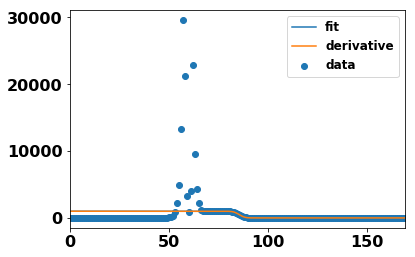

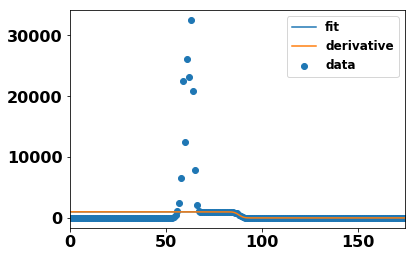

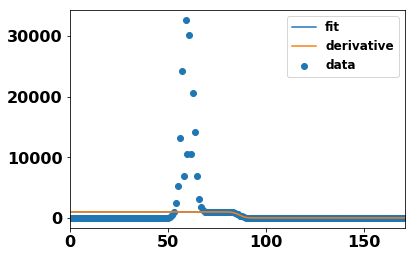

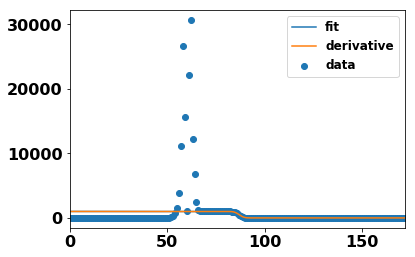

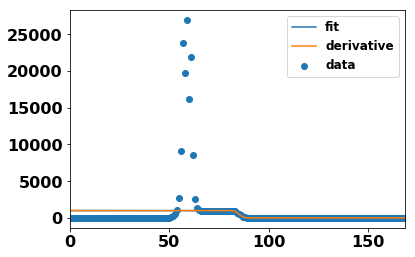

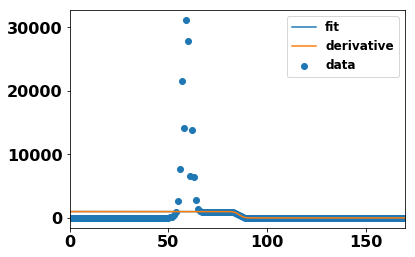

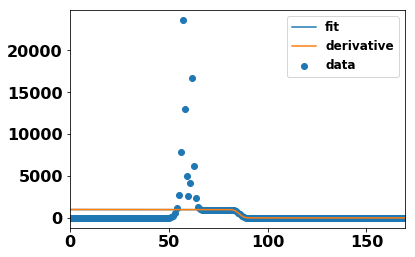

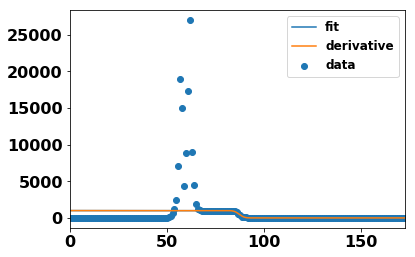

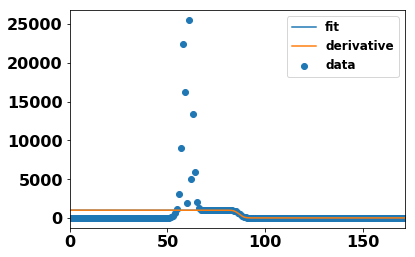

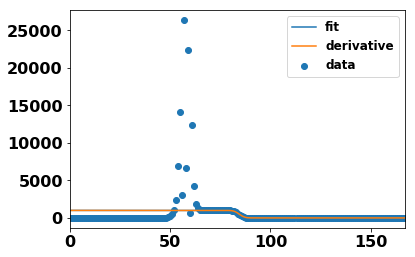

In [62]:
mean_der = []
rms_der = []

for i in range(0,curves.shape[1]):
    out = derivative(curves[i])
    mean_der += [out[0]]
    rms_der += [out[1]]
    
    if i<10:
        fig, ax = plt.subplots()
        plt.scatter(np.linspace(0,255,256),curves[i],label='data')

        curve_fit = [500*(erfc((x-mean_fit[i])/rms_fit[i])) for x in np.linspace(0,255,512)]
        # NB fit is offset by 1 in DAC
        plt.plot(np.linspace(1,256,512),curve_fit,label='fit')
        
        curve_der = [500*(erfc((x-out[0])/(np.sqrt(2)*out[1]))) for x in np.linspace(0,255,512)]
        plt.plot(np.linspace(0,255,512),curve_der,label='derivative')
        
        ax.set_xlim(0,2*mean_fit[i])
        plt.legend(loc='upper right',prop={'size': 12});

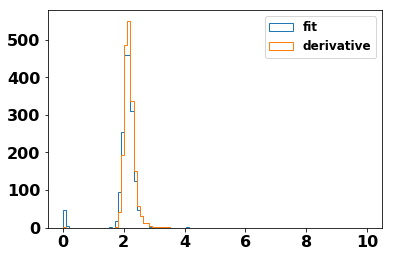

In [63]:
plt.hist(rms_fit/np.sqrt(2),histtype='step',bins=np.linspace(0,10,100));
plt.hist(rms_der,histtype='step',bins=np.linspace(0,10,100));
plt.legend(['fit','derivative'],loc='upper right',prop={'size': 12});

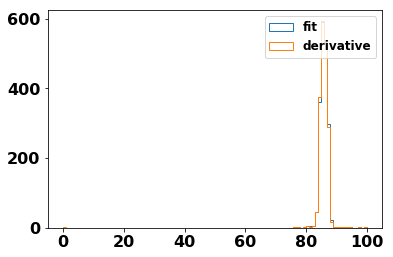

In [64]:
plt.hist(mean_fit+1,histtype='step',bins=np.linspace(0,100,100));
plt.hist(mean_der,histtype='step',bins=np.linspace(0,100,100));
plt.legend(['fit','derivative'],loc='upper right',prop={'size': 12})

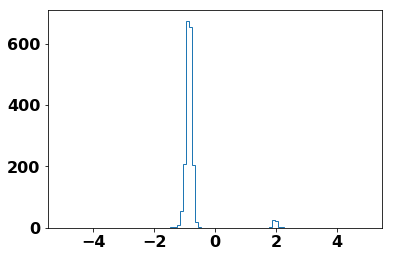

In [65]:
plt.hist(rms_der-rms_fit,bins=np.linspace(-5,5,100),histtype='step');

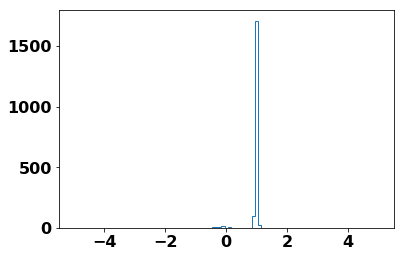

In [66]:
plt.hist(mean_der-mean_fit,bins=np.linspace(-5,5,100),histtype='step');